<a href="https://colab.research.google.com/github/hongjai-rhee/public/blob/master/cascade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Information cascade
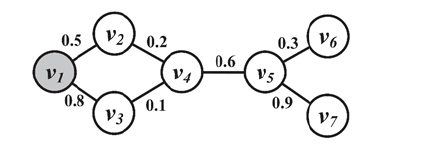

# 라이브러리 불러오기

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf; import matplotlib as mpl; import matplotlib.pyplot as plt
import numpy as np; import os ; import pandas as pd


## 데이터 불러오기

In [0]:
df = pd.read_csv('sentiment.csv')
#df.head()
uni_data = df['flow2']
print(uni_data.head())   # 1=positive, 0=negative
uni_data.plot(subplots=True)

##훈련, 검증용으로 나누기

In [0]:
PAST=10                                ## 과거 몇 기까지를 X로 할 것인가?
TRAIN_SPLIT = np.int(0.7*df.shape[0])  ## 70%를 훈련용으로, 나머지 검증용으로 배치

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

uni_data = uni_data.values

univariate_past_history = PAST
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print ('Window of past history', '===> Target to predict')
for i in range(5):
  print (np.transpose(x_train_uni[i]),'     ', y_train_uni[i])


# 예측문제 시각화

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

# LSTM 모형설정
LSTM is a type of neural network well-suited to time series data. 

In [0]:
BATCH_SIZE = 256    # hyper parameters
BUFFER_SIZE = 1000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

simple_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 학습하기

In [0]:
EPOCHS = 10; EVALUATION_INTERVAL = 200

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

# 예측하기

In [0]:
x_test = pd.read_csv('x_test.csv')
x_test.head(7)
x1=np.array(x_test)
x1=x1.reshape(7,10,1)
#print(x1)
yhat=simple_lstm_model.predict(x1)

print('Flow of past sentiments', '     Prob of POSITIVE sentiment')
print()
for i in range(7):
  print(np.transpose(x1[i]),'====>', yhat[i])
  print()